In [1]:
# importing the required modules

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from tqdm import tqdm

Frequency of the original square wave: 3.3069057421676504 Hz
Amplitude: 0.09961268720975147
Phase: 89.96664574840116
Frequency: 3.3069057421676504

Original Amplitude: 0.1
Original Phase: 90.0
Original Frequency: 3.3


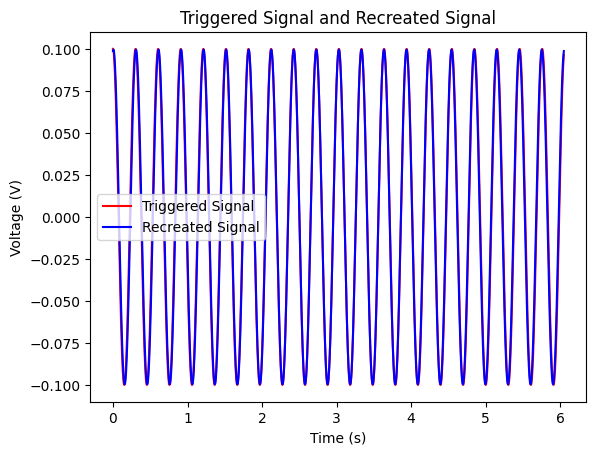

In [11]:
# info about the data
f = 3.3 # initial frequency
freq_sampling =  114795 / 5.78562
noise_add = False
triggering = False
triggering_mode = 'falling' # rising or falling
N_sample = 120000 # number of samples
Total_time = N_sample / freq_sampling # total time
time_vary = False

amplitudes = [0.05, 0.07, 0.1, 0.12, 0.15] # amplitudes of the signal

phases = [0, np.pi/8, 2 * np.pi/8, 3 * np.pi/8, 4 * np.pi/8, 5 * np.pi/8, 6 * np.pi/8, 7 * np.pi/8] # phases of the signal
phases = [0, np.pi/4, np.pi/2, 3 * np.pi/4, np.pi,
          5 * np.pi/4, 6 * np.pi/4, 7 * np.pi/4, 2 * np.pi] # phases of the signal
# phases = [0, np.pi/4, np.pi/2, 3 * np.pi/4, np.pi,
#             5 * np.pi/4, 6 * np.pi/4, 7 * np.pi/4, 2 * np.pi,
#           -np.pi/4, -np.pi/2, -3 * np.pi/4, -np.pi,
#             -5 * np.pi/4, -6 * np.pi/4, -7 * np.pi/4, -2 * np.pi] # phases of the signal

dc_signal = 0.0 # dc signal

# random amplitude
amplitude = amplitudes[np.random.randint(0, len(amplitudes))]
phase = phases[np.random.randint(0, len(phases))]

# manually setting the amplitude and phase/
# amplitude = 0.001
# phase = np.pi/4

t = np.linspace(0, Total_time, N_sample, endpoint=False) # time array

# creating a sin wave with the frequency array
y = amplitude * np.sin(2 * np.pi * f * t + phase) + dc_signal

# adding some noise to the signal
if noise_add:
    y = y + 0.001 * np.random.normal(size=t.size)

# creeating a squarae wave with the frequency array and a phase shift of 90 degrees
y_square = 0.05*np.sin(2 * np.pi * f * t)

# converting the signal to a square wave
y_square = 0.025 * np.sign(y_square) + 0.025

# adding some noise to the signal
if noise_add:
    y_square = y_square + 0.0009 * np.random.normal(size=t.size)

if time_vary:
    t_cycle = 1/f
    N_cycle = N_sample * (t_cycle / Total_time)
    rand_idx = np.random.randint(0, int(N_cycle))

    N_sample = N_sample - (2 * rand_idx)

    t = t[rand_idx: N_sample + rand_idx]
    y = y[rand_idx: N_sample + rand_idx]
    y_square = y_square[rand_idx: N_sample + rand_idx]



if triggering:
    # centralizing the reference signal
    y_square_max = np.max(y_square)
    y_square_min = np.min(y_square)
    y_square = y_square - ((y_square_max + y_square_min)/2)

    if triggering_mode == 'rising':
        first_rise_idx = 0
        for i in range(1, N_sample):
            if y_square[i] > 0 and y_square[i-1] < 0:
                first_rise_idx = i
                break
    if triggering_mode == 'falling':
        first_rise_idx = 0
        for i in range(1, N_sample):
            if y_square[i] < 0 and y_square[i-1] > 0:
                first_rise_idx = i
                break

    # triggered signal, reference signal and time
    triggered_sig = y[first_rise_idx:]
    triggered_ref = y_square[first_rise_idx:]
    triggered_time = t[first_rise_idx:] - t[first_rise_idx] # time starts from zero
else:
    triggered_sig = y
    triggered_ref = y_square
    triggered_time = t


# fft on the original reference signal
yf = fft(y_square)[1:]
xf = fftfreq(N_sample, 1 / freq_sampling)[1:]
freq = xf[np.argmax(np.abs(yf))]
print('Frequency of the original square wave:', freq, 'Hz')

# creating sin and cos reference signals
ref_sin = 2 * np.sin(2 * np.pi * freq * triggered_time)
ref_cos = 2 * np.cos(2 * np.pi * freq * triggered_time)

# multiplying the triggered signal with the sin and cos reference signals
y_sin = triggered_sig * ref_sin
y_cos = triggered_sig * ref_cos

# taking the fft of the multiplied signals and finding the dc components
yf_sin = fft(y_sin)
yf_cos = fft(y_cos)

# finding the dc components
dc_sin = yf_sin[0].real / (len(ref_sin))
dc_cos = yf_cos[0].real / (len(ref_cos))

# finding voltage amplitude and phase
A = np.sqrt(dc_sin**2 + dc_cos**2)
phi = np.arctan(dc_cos/dc_sin)
if phi < 0:
    phi = phi + 2 * np.pi
# phi = np.degrees(phi)

print('Amplitude:', A)
print('Phase:', np.degrees(phi) + 7.5)
print('Frequency:', freq)

print('\nOriginal Amplitude:', amplitude)
print('Original Phase:', np.degrees(phase))
print('Original Frequency:', f)

# # # plotting the current signal and the reference signal
# plt.plot(t, y, 'g',label='Noisy Signal')
# # plt.plot(t, y, 'r',label='Original Signal')
# plt.plot(t, y_square, 'b',label='Noisy Reference')
# # plt.plot(t, y_square, 'y',label='Original Reference')
# plt.title('Signal vs Time')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.grid()
# plt.show()

# # plotting the triggered signals
# plt.plot(triggered_time, triggered_sig, 'r', label='Triggered Signal')
# plt.plot(triggered_time, triggered_ref, 'b', label='Triggered Reference')
# plt.xlabel('Time (s)')
# plt.ylabel('Voltage (V)')
# plt.title('Triggered Signal and Reference')
# plt.legend()
# plt.show()

# plot the observed signal and the recreated signal
plt.plot(triggered_time, triggered_sig, 'r', label='Triggered Signal')
plt.plot(triggered_time, A * np.sin(2 * np.pi * freq * triggered_time + phi), 'b', label='Recreated Signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Triggered Signal and Recreated Signal')
plt.legend()
plt.show()


Phases at which there is a $180\degree$ phase difference between answers:
- 135
- 180
- 225
- 270

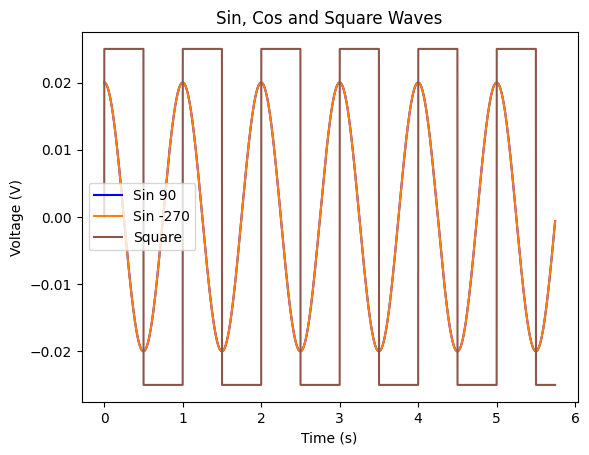

In [106]:
sq = 0.025 * np.sign(np.sin(2 * np.pi * 1 * triggered_time ))
sin = 0.02*np.sin(2 * np.pi * 1 * triggered_time)
sin_90 = 0.02*np.sin(2 * np.pi * 1 * triggered_time + np.pi/2)
sin_180 = 0.02*np.sin(2 * np.pi * 1 * triggered_time + np.pi)
sin_270 = 0.02*np.sin(2 * np.pi * 1 * triggered_time + 3*np.pi/2)
sin_360 = 0.02*np.sin(2 * np.pi * 1 * triggered_time + 2*np.pi)
sin_neg_90 = 0.02*np.sin(2 * np.pi * 1 * triggered_time - np.pi/2)
sin_neg_180 = 0.02*np.sin(2 * np.pi * 1 * triggered_time - np.pi)
sin_neg_270 = 0.02*np.sin(2 * np.pi * 1 * triggered_time - 3*np.pi/2)
sin_neg_360 = 0.02*np.sin(2 * np.pi * 1 * triggered_time - 2*np.pi)


# plt.plot(triggered_time, sin, 'r', label='Sin')
plt.plot(triggered_time, sin_90, 'b', label='Sin 90')
# plt.plot(triggered_time, sin_180, 'g', label='Sin 180')
# plt.plot(triggered_time, sin_270, 'y', label='Sin 270')
# plt.plot(triggered_time, sin_360, 'c', label='Sin 360')
# plt.plot(triggered_time, sin_neg_90, 'm', label='Sin -90')
# plt.plot(triggered_time, sin_neg_180, 'k', label='Sin -180')
plt.plot(triggered_time, sin_neg_270, 'tab:orange', label='Sin -270')
# plt.plot(triggered_time, sin_neg_360, 'tab:purple', label='Sin -360')
plt.plot(triggered_time, sq, 'tab:brown', label='Square')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Sin, Cos and Square Waves')
plt.legend()
plt.show()

In [49]:
#Checking which phase gives the best results

# info about the data
f = 3.3 # initial frequency
freq_sampling =  114795 / 5.78562
noise_add = False
triggering = False
triggering_mode = 'falling' # rising or falling
N_sample = 12000 # number of samples
Total_time = N_sample / freq_sampling # total time
time_vary = False

dc_signal = 0.0 # dc signal

# manually setting the amplitude and phase/
amplitude = 0.001
phases = np.linspace(0, 2*np.pi, 3601)[:-1]
tolerance = np.deg2rad(3)
print('Tolerance:', np.rad2deg(tolerance))
phis = []

for phase in tqdm(phases):
    t = np.linspace(0, Total_time, N_sample, endpoint=False) # time array

    # creating a sin wave with the frequency array
    y = amplitude * np.sin(2 * np.pi * f * t + phase) + dc_signal

    # adding some noise to the signal
    if noise_add:
        y = y + 0.001 * np.random.normal(size=t.size)

    # creeating a squarae wave with the frequency array and a phase shift of 90 degrees
    y_square = 0.05*np.sin(2 * np.pi * f * t)

    # converting the signal to a square wave
    y_square = 0.025 * np.sign(y_square) + 0.025

    # adding some noise to the signal
    if noise_add:
        y_square = y_square + 0.0009 * np.random.normal(size=t.size)

    if time_vary:
        t_cycle = 1/f
        N_cycle = N_sample * (t_cycle / Total_time)
        rand_idx = np.random.randint(0, int(N_cycle))

        N_sample = N_sample - (2 * rand_idx)

        t = t[rand_idx: N_sample + rand_idx]
        y = y[rand_idx: N_sample + rand_idx]
        y_square = y_square[rand_idx: N_sample + rand_idx]



    if triggering:
        # centralizing the reference signal
        y_square_max = np.max(y_square)
        y_square_min = np.min(y_square)
        y_square = y_square - ((y_square_max + y_square_min)/2)

        if triggering_mode == 'rising':
            first_rise_idx = 0
            for i in range(1, N_sample):
                if y_square[i] > 0 and y_square[i-1] < 0:
                    first_rise_idx = i
                    break
        if triggering_mode == 'falling':
            first_rise_idx = 0
            for i in range(1, N_sample):
                if y_square[i] < 0 and y_square[i-1] > 0:
                    first_rise_idx = i
                    break

        # triggered signal, reference signal and time
        triggered_sig = y[first_rise_idx:]
        triggered_ref = y_square[first_rise_idx:]
        triggered_time = t[first_rise_idx:] - t[first_rise_idx] # time starts from zero
    else:
        triggered_sig = y
        triggered_ref = y_square
        triggered_time = t


    # fft on the original reference signal
    yf = fft(y_square)[1:]
    xf = fftfreq(N_sample, 1 / freq_sampling)[1:]
    freq = xf[np.argmax(np.abs(yf))]
    # print('Frequency of the original square wave:', freq, 'Hz')

    # creating sin and cos reference signals
    ref_sin = 2 * np.sin(2 * np.pi * freq * triggered_time)
    ref_cos = 2 * np.cos(2 * np.pi * freq * triggered_time)

    # multiplying the triggered signal with the sin and cos reference signals
    y_sin = triggered_sig * ref_sin
    y_cos = triggered_sig * ref_cos

    # taking the fft of the multiplied signals and finding the dc components
    yf_sin = fft(y_sin)
    yf_cos = fft(y_cos)

    # finding the dc components
    dc_sin = yf_sin[0].real / (len(ref_sin))
    dc_cos = yf_cos[0].real / (len(ref_cos))

    # finding voltage amplitude and phase
    A = np.sqrt(dc_sin**2 + dc_cos**2)
    phi = np.arctan2(dc_cos,dc_sin)
    if phi < 0:
        phi = phi + 2 * np.pi
    # phi = np.degrees(phi)
        
    phis.append(phi)


Tolerance: 3.0000000000000004


100%|██████████| 3600/3600 [00:02<00:00, 1510.66it/s]


In [50]:
phis2 = np.rad2deg(phis)
phases2 = np.rad2deg(phases)

for i in range(len(phis2)):
    if phis2[i] < 0:
        phis2[i] = phis2[i] + 360
print(phis2[0])

359.2499144134968


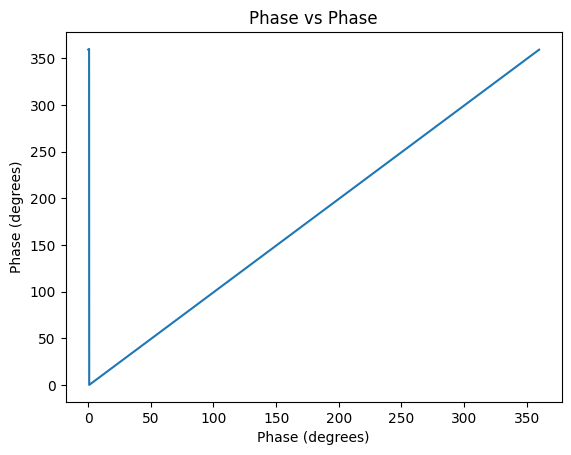

In [51]:
plt.plot(phases2, phis2)
plt.xlabel('Phase (degrees)')
plt.ylabel('Phase (degrees)')
plt.title('Phase vs Phase')
plt.show()

In [48]:
print(f'freq_sampling = {freq_sampling}')
print(f' fs / f = {freq_sampling/f}')

freq_sampling = 19841.434453005902
 fs / f = 6012.555894850274


### studying shift in answer


In [69]:
# info about the data
f = 3.3 # initial frequency
freq_sampling =  114795 / 5.78562
noise_add = False
triggering = False
triggering_mode = 'falling' # rising or falling
N_sample = 18000 # number of samples
Total_time = N_sample / freq_sampling # total time
time_vary = False

dc_signal = 0.0 # dc signal

# manually setting the amplitude and phase/
amplitude = 0.001
phase = 0
tolerance = np.deg2rad(3)
print('Tolerance:', np.rad2deg(tolerance))
phis = []

t = np.linspace(0, Total_time, N_sample, endpoint=False) # time array

# creating a sin wave with the frequency array
y = amplitude * np.sin(2 * np.pi * f * t + phase) + dc_signal

# adding some noise to the signal
if noise_add:
    y = y + 0.001 * np.random.normal(size=t.size)

# creeating a squarae wave with the frequency array and a phase shift of 90 degrees
y_square = 0.05*np.sin(2 * np.pi * f * t)

# converting the signal to a square wave
y_square = 0.025 * np.sign(y_square) + 0.025

# adding some noise to the signal
if noise_add:
    y_square = y_square + 0.0009 * np.random.normal(size=t.size)

if time_vary:
    t_cycle = 1/f
    N_cycle = N_sample * (t_cycle / Total_time)
    rand_idx = np.random.randint(0, int(N_cycle))

    N_sample = N_sample - (2 * rand_idx)

    t = t[rand_idx: N_sample + rand_idx]
    y = y[rand_idx: N_sample + rand_idx]
    y_square = y_square[rand_idx: N_sample + rand_idx]



if triggering:
    # centralizing the reference signal
    y_square_max = np.max(y_square)
    y_square_min = np.min(y_square)
    y_square = y_square - ((y_square_max + y_square_min)/2)

    if triggering_mode == 'rising':
        first_rise_idx = 0
        for i in range(1, N_sample):
            if y_square[i] > 0 and y_square[i-1] < 0:
                first_rise_idx = i
                break
    if triggering_mode == 'falling':
        first_rise_idx = 0
        for i in range(1, N_sample):
            if y_square[i] < 0 and y_square[i-1] > 0:
                first_rise_idx = i
                break

    # triggered signal, reference signal and time
    triggered_sig = y[first_rise_idx:]
    triggered_ref = y_square[first_rise_idx:]
    triggered_time = t[first_rise_idx:] - t[first_rise_idx] # time starts from zero
else:
    triggered_sig = y
    triggered_ref = y_square
    triggered_time = t


# fft on the original reference signal
yf = fft(y_square)[1:]
xf = fftfreq(N_sample, 1 / freq_sampling)[1:]
freq = xf[np.argmax(np.abs(yf))]
# print('Frequency of the original square wave:', freq, 'Hz')

# creating sin and cos reference signals
ref_sin = 2 * np.sin(2 * np.pi * freq * triggered_time)
ref_cos = 2 * np.cos(2 * np.pi * freq * triggered_time)

# multiplying the triggered signal with the sin and cos reference signals
y_sin = triggered_sig * ref_sin
y_cos = triggered_sig * ref_cos

# taking the fft of the multiplied signals and finding the dc components
yf_sin = fft(y_sin)
yf_cos = fft(y_cos)

# finding the dc components
dc_sin = yf_sin[0].real / (len(ref_sin))
dc_cos = yf_cos[0].real / (len(ref_cos))

# finding voltage amplitude and phase
A = np.sqrt(dc_sin**2 + dc_cos**2)
phi = np.arctan2(dc_cos,dc_sin)
if phi < 0:
    phi = phi + 2 * np.pi

print('Amplitude:', A)
print('Phase:', np.degrees(phi))
print('Frequency:', freq)

print('\nOriginal Amplitude:', amplitude)
print('Original Phase:', np.degrees(phase))
print('Original Frequency:', f)

Tolerance: 3.0000000000000004
Amplitude: 0.0010009797519280293
Phase: 358.8748086844386
Frequency: 3.306905742167651

Original Amplitude: 0.001
Original Phase: 0.0
Original Frequency: 3.3


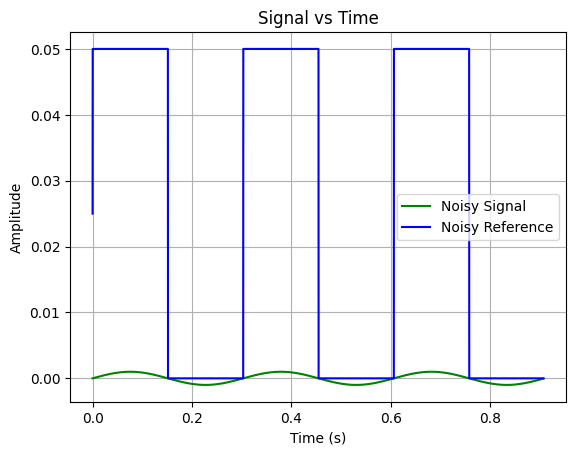

In [70]:
# plotting the current signal and the reference signal
plt.plot(t, y, 'g',label='Noisy Signal')
# plt.plot(t, y, 'r',label='Original Signal')
plt.plot(t, y_square, 'b',label='Noisy Reference')
# plt.plot(t, y_square, 'y',label='Original Reference')
plt.title('Signal vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()